In [36]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# visualization
import matplotlib.pyplot as plt

In [37]:
start_time = utility.time.time()

stop_thread = False

# global parameters
max_cpu_usage = 0
max_memory_usage = 0

def collect_cpu_mem_usage():
    global max_cpu_usage, max_memory_usage

    while not stop_thread:
        # Get current CPU and memory usage
        cpu_usage = utility.psutil.cpu_percent()
        memory_usage = utility.psutil.virtual_memory().percent

        # Initialize variables if not yet assigned
        if max_cpu_usage is None:
            max_cpu_usage = cpu_usage
        if max_memory_usage is None:
            max_memory_usage = memory_usage

        # Update maximum values if needed
        max_cpu_usage = max(max_cpu_usage, cpu_usage)
        max_memory_usage = max(max_memory_usage, memory_usage)

        # Sleep for a short interval (adjust as needed)
        utility.time.sleep(1)

# Start the function in a separate thread
thread = utility.threading.Thread(target=collect_cpu_mem_usage)
thread.start()

In [38]:
data, labels, _ = utility.load_data()

Dataset split: 70000 train rows
Dataset split: 70000 test rows


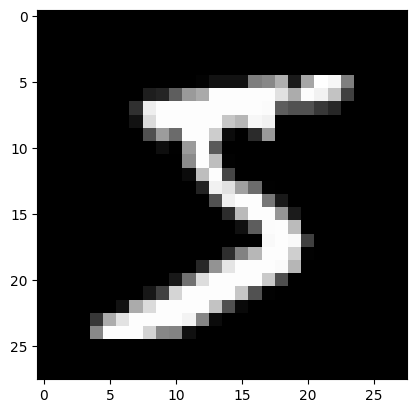

In [39]:
print(f"Dataset split: {len(data)} train rows")
print(f"Dataset split: {len(labels)} test rows")

point = data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [40]:
train_data, train_labels, test_data, test_labels, val_data, val_labels, test_true_labels, anom_data = utility.preprocess_data(data, labels)

In [41]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [42]:
# parameters
epochs = 200
batch_size = 64
optimizer = 'adam'
loss = MeanSquaredError()
dropout_rate = 0.2
activation = 'tanh'

In [43]:
latent_dim = 2

In [44]:
# encoder
vae_input = Input(shape=(784,))
x = Dense(256, activation='relu')(vae_input)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=dropout_rate)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [45]:
z = Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [46]:
# decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_input)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(784, activation=activation)(x)
decoded = x

In [47]:
# Encoder model
encoder = Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = Model(inputs=decoder_input, outputs=decoded)

In [48]:
vae_output = decoder(encoder(vae_input)[2])
vae = Model(inputs=vae_input, outputs=vae_output)

In [49]:
vae.compile(optimizer=optimizer, loss=loss)

In [50]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Adding the early stopping callback to the fit method
history = vae.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_data), callbacks=[early_stopping])

Epoch 1/200


700/700 [==============================] - 4s 4ms/step - loss: 0.0525 - val_loss: 0.0459
Epoch 2/200
700/700 [==============================] - 3s 4ms/step - loss: 0.0461 - val_loss: 0.0436
Epoch 3/200
700/700 [==============================] - 3s 4ms/step - loss: 0.0444 - val_loss: 0.0424
Epoch 4/200
700/700 [==============================] - 3s 4ms/step - loss: 0.0435 - val_loss: 0.0416
Epoch 5/200
700/700 [==============================] - 3s 4ms/step - loss: 0.0428 - val_loss: 0.0409
Epoch 6/200
700/700 [==============================] - 2s 4ms/step - loss: 0.0423 - val_loss: 0.0406
Epoch 7/200
700/700 [==============================] - 2s 3ms/step - loss: 0.0418 - val_loss: 0.0399
Epoch 8/200
700/700 [==============================] - 3s 4ms/step - loss: 0.0415 - val_loss: 0.0397
Epoch 9/200
700/700 [==============================] - 3s 4ms/step - loss: 0.0411 - val_loss: 0.0397
Epoch 10/200
700/700 [==============================] - 2s 4ms/step - loss: 0.0409 - val_loss: 0.0391
E

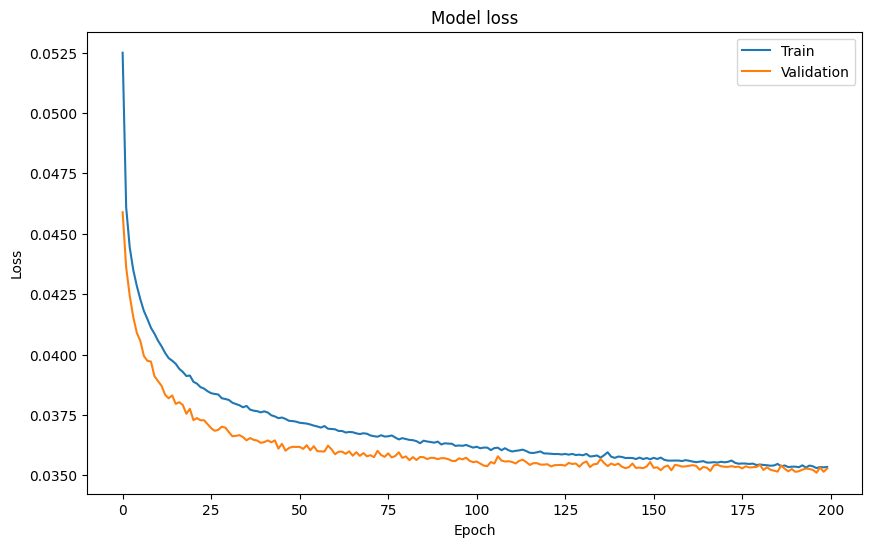

In [51]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

313/313 [==============================] - 0s 1ms/step


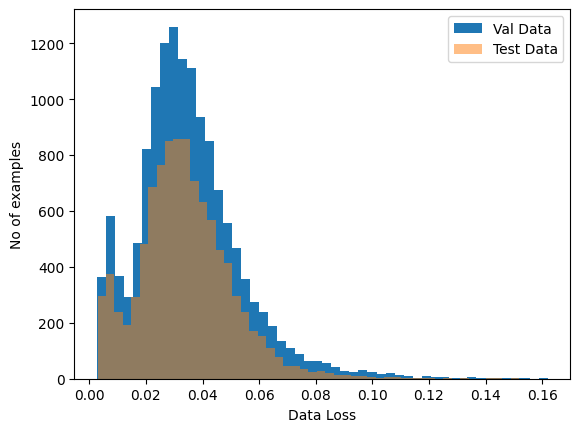

In [52]:
reconstructions = vae.predict(val_data)
val_loss = tf.keras.losses.mse(reconstructions, val_data)

reconstructions_test = vae.predict(test_data)
test_loss = tf.keras.losses.mse(reconstructions_test, test_data)

plt.hist(val_loss[None,:], bins=50, label='Val Data')
plt.hist(test_loss[None,:], bins=50, alpha=0.5, label='Test Data')
plt.xlabel("Data Loss")
plt.ylabel("No of examples")
plt.legend()
plt.show()

In [53]:
threshold = np.mean(val_loss) + np.std(val_loss)
print("Threshold ", threshold)

# Choose a quantile (e.g., 99th percentile) for the threshold
# threshold = np.percentile(train_loss, 99)
# print("Quantile Threshold ", threshold)

Threshold  0.053785082


In [54]:
threshold_anom = np.mean(test_loss) + np.std(test_loss)
print("Threshold ", threshold_anom)

Threshold  0.050314195


In [55]:
preds, loss, proba = utility.predict(vae, test_data, threshold)

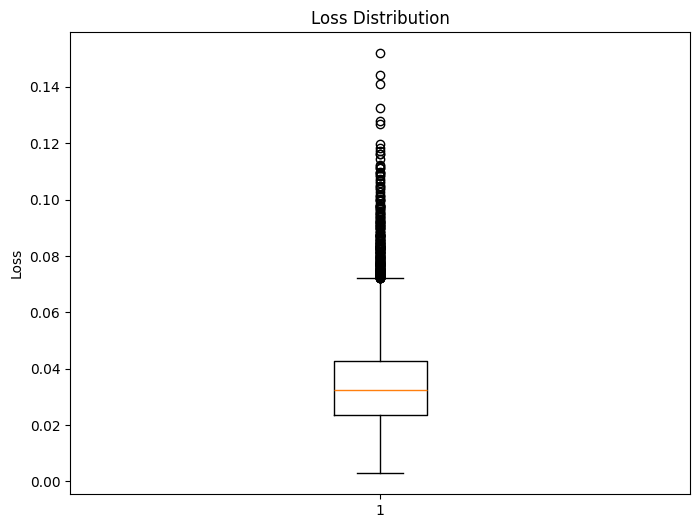

In [56]:
q1, q3, iqr, minimum, maximum = utility.boxplot_plot("Loss", loss)

In [57]:
utility.print_boxplot(q1, q3, iqr, minimum, maximum)

Q1:  0.023
Q3:  0.043
IQR:  0.019
Minimum:  0.003
Maximum:  0.072


C:\Users\zippe\AppData\Local\Temp\ipykernel_19136\1046356683.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')


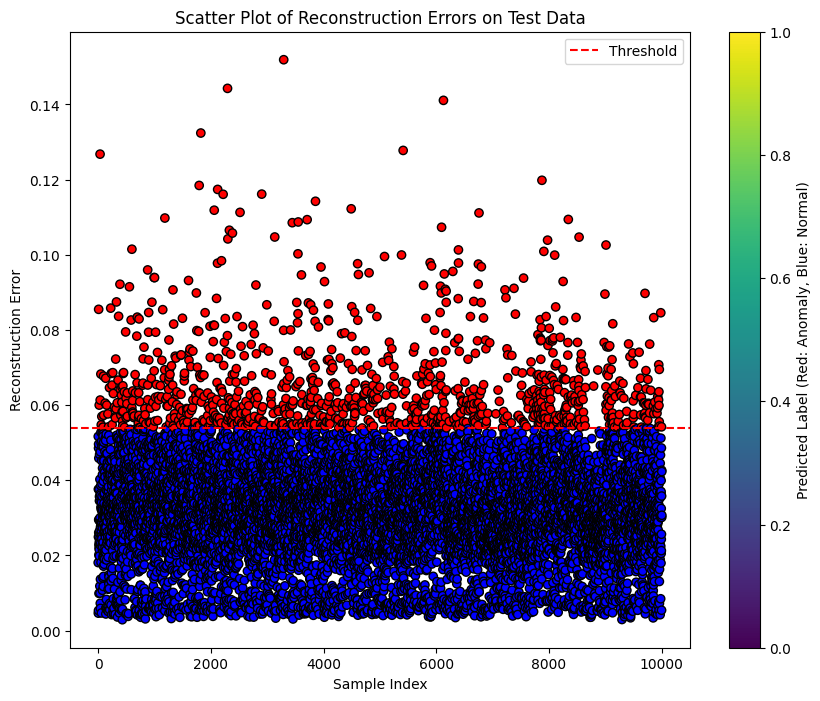

In [58]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(loss > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [59]:
a, p, r, f1, report, cm = utility.get_metrics(preds, test_true_labels)

In [60]:
utility.print_stats(a, p, r, f1, report, cm)

Accuracy = 0.8990403838464615
Precision = 0.9998887900355872
Recall = 0.8991
F1 = 0.9468197135636057
Report
               precision    recall  f1-score   support

     anomaly       0.00      0.75      0.01         4
      normal       1.00      0.90      0.95     10000

    accuracy                           0.90     10004
   macro avg       0.50      0.82      0.48     10004
weighted avg       1.00      0.90      0.95     10004

Confusion Matrix
[[   3    1]
 [1009 8991]]


True Negatives: 3
False Positives: 1
False Negatives: 1009
True Positives: 8991


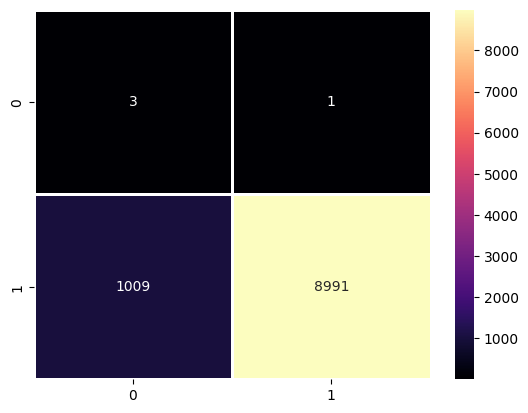

In [61]:
utility.create_heatmap(cm)

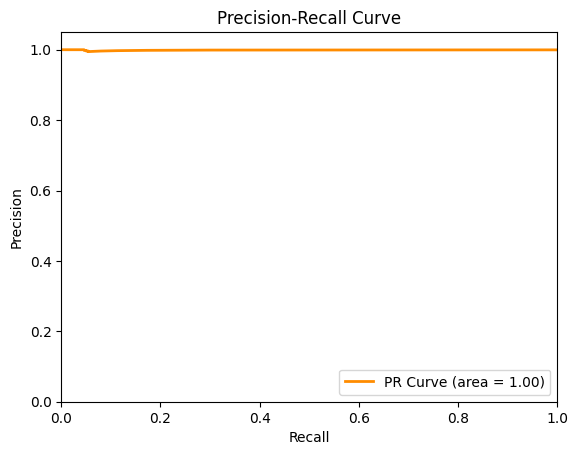

In [62]:
utility.pr_auc_plot(proba, test_true_labels)

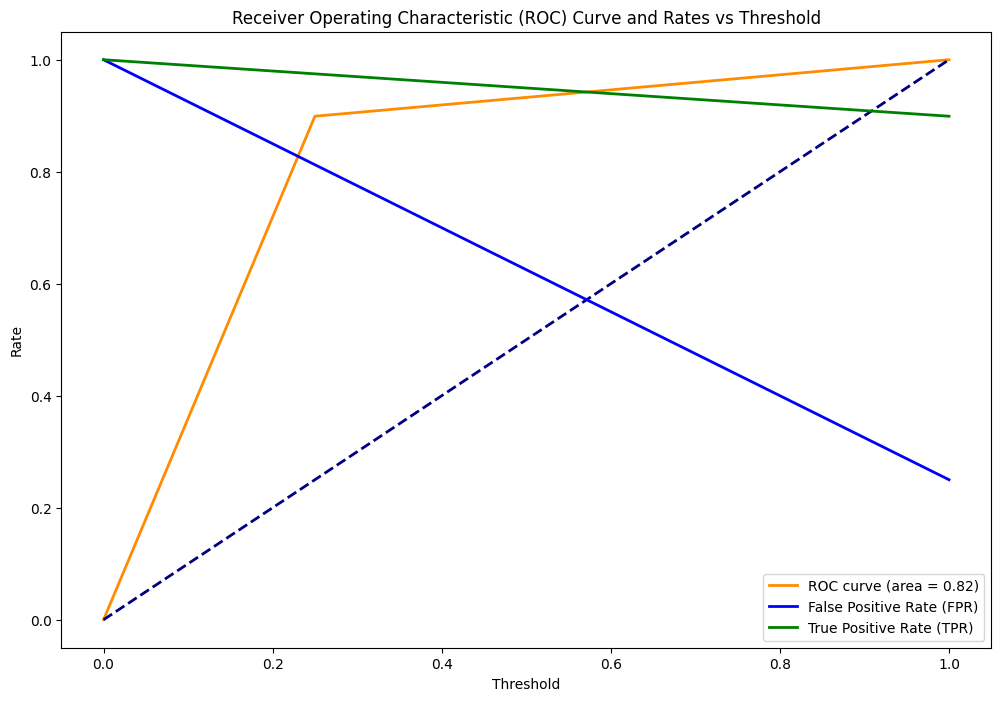

In [63]:
utility.roc_plot(preds, test_true_labels)

In [64]:
reconstructions = vae.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)

reconstructions_test = vae.predict(test_data)
test_loss = tf.keras.losses.mse(reconstructions_test, test_data)

reconstructions_anom = vae.predict(anom_data)
anom_loss = tf.keras.losses.mse(reconstructions_anom, anom_data)

1/1 [==============================] - 0s 17ms/step


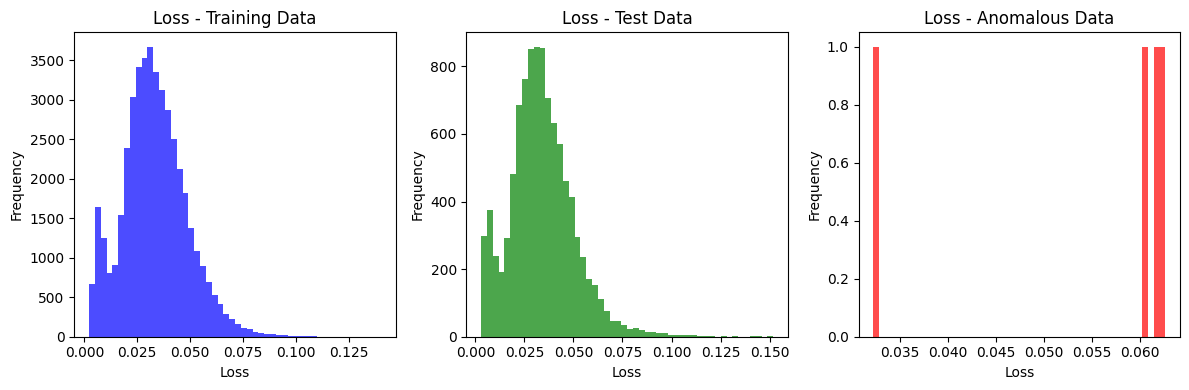

In [65]:
# Plotting histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(train_loss[None,:], bins=50, color='blue', alpha=0.7)
plt.title('Loss - Training Data')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(test_loss[None,:], bins=50, color='green', alpha=0.7)
plt.title('Loss - Test Data')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(anom_loss[None,:], bins=50, color='red', alpha=0.7)
plt.title('Loss - Anomalous Data')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [66]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


1012


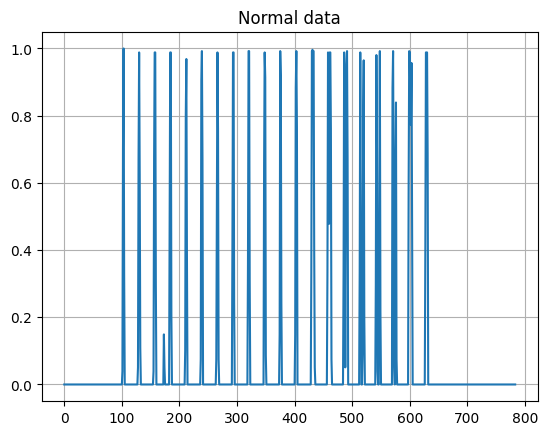

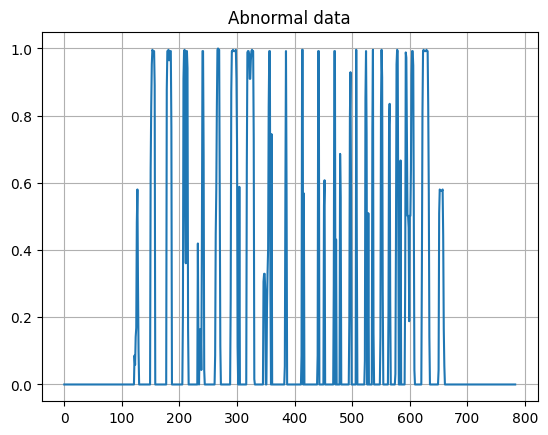

In [67]:
print(len(anomaly_indexes))

utility.plot_normalized_pixel_data(train_data, anom_data)

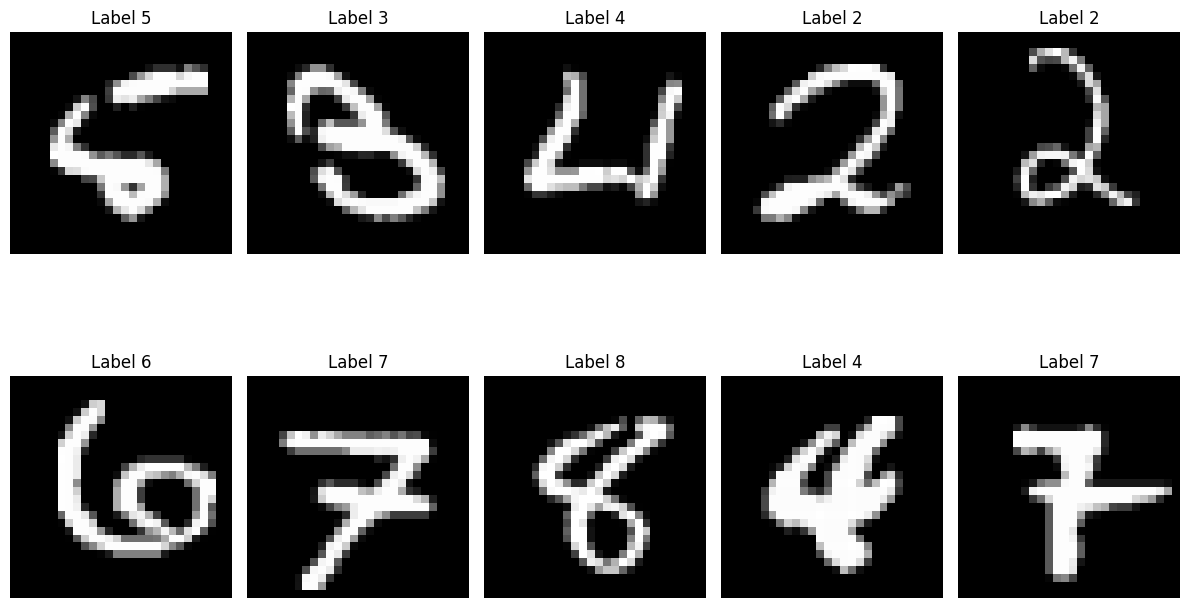

In [68]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data, test_labels)

In [69]:
stop_thread = True

thread.join()
print(f"CPU Usage: {max_cpu_usage}%")
print(f"Memory Usage: {max_memory_usage}%")

CPU Usage: 9.3%
Memory Usage: 35.9%


In [70]:
end_time = utility.time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")

Total execution time: 513.147378206253 seconds
